In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
from datetime import datetime
import statsmodels.api as sm

# %matplotlib inline

# https://www.kaggle.com/agirlcoding/all-space-missions-from-1957
df = pd.read_csv('./datasets_828921_1417131_Space_Corrected.csv')
df.head()
print(df.columns)



Index(['Unnamed: 0', 'Unnamed: 0.1', 'Company Name', 'Location', 'Datum',
       'Detail', 'Status Rocket', ' Rocket', 'Status Mission'],
      dtype='object')


In [4]:
# Rename a few columns to remove spaces
df = df.rename(columns={"Company Name": "Company_Name", "Status Rocket": "Rocket_Status", "Status Mission": "Mission_Status", " Rocket": "Rocket_Price"})

# Create column for Success/Failure. Recode partial failures as failures
def Success_Fail(series):
	if series == 'Prelaunch Failure':
		return "Failure"
	elif series == 'Partial Failure':
		return "Failure"
	elif series == 'Failure':
		return "Failure"
	elif series == 'Success':
		return "Success"

df['SucessFail'] = df['Mission_Status'].apply(Success_Fail)
print(df.SucessFail.unique())


['Success' 'Failure']


In [5]:
# function to return Date Portion of string
def get_date_chars(string):
    return str(string)[4:16]
df["date_string"] = df['Datum'].apply(get_date_chars)

# Strip out the commas from date field
df["date_string"] = df.date_string.replace(',','', regex=True)

# function to return date_time field
def get_date_time(string):
    return datetime.strptime(string, "%b %d %Y")
df["date_time"] = df['date_string'].apply(get_date_time)

# Get Fields for Year and Month  
df['YEAR'] = pd.DatetimeIndex(df['date_time']).year
df['MONTH'] = pd.DatetimeIndex(df['date_time']).month
df['WEEK'] = df['date_time'].dt.isocalendar().week

# get Field for weekday
def get_date_chars(string):
    return str(string)[0:3]
df["WEEKDAY"] = df['Datum'].apply(get_date_chars)

# Clean up Rocket_Price
# strip commas
df["Rocket_Price"] = df.Rocket_Price.replace(',','', regex=True)
# Convert Rocket Price to numeric
df['Rocket_Price'] = pd.to_numeric(df['Rocket_Price'])


# Get our Datafields we want to play with
space_df = df[['SucessFail', 'Company_Name', 'Rocket_Price', 'date_time', 'YEAR', 'MONTH', 'WEEK', 'WEEKDAY']]

# create dummy columns for success/fail
sf = pd.get_dummies(space_df['SucessFail'])
# combine resulting dataframe with orginal
frames = [space_df, sf]
space_df = pd.concat(frames, axis=1)
print(space_df.head)


<bound method NDFrame.head of      SucessFail Company_Name  Rocket_Price  date_time  YEAR  MONTH  WEEK  \
0       Success       SpaceX         50.00 2020-08-07  2020      8    32   
1       Success         CASC         29.75 2020-08-06  2020      8    32   
2       Success       SpaceX           NaN 2020-08-04  2020      8    32   
3       Success    Roscosmos         65.00 2020-07-30  2020      7    31   
4       Success          ULA        145.00 2020-07-30  2020      7    31   
...         ...          ...           ...        ...   ...    ...   ...   
4319    Failure      US Navy           NaN 1958-02-05  1958      2     6   
4320    Success         AMBA           NaN 1958-02-01  1958      2     5   
4321    Failure      US Navy           NaN 1957-12-06  1957     12    49   
4322    Success    RVSN USSR           NaN 1957-11-03  1957     11    44   
4323    Success    RVSN USSR           NaN 1957-10-04  1957     10    40   

     WEEKDAY  Failure  Success  
0        Fri        0   

# Question: Which company has highest success rate? 

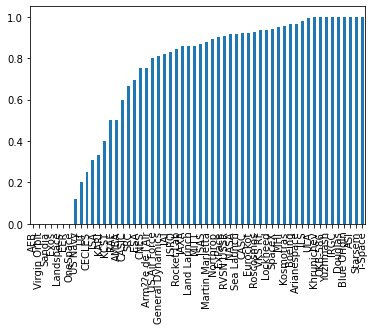

In [6]:
# Create df with each row = company; columns = ['Company_Name' 'success_rate', 'n']
# Get Success Rate by company
success_rate = space_df.groupby(['Company_Name'])['Success'].mean()
# Get number of launches
company_n = space_df.Company_Name.value_counts()

# Combine summary dat
frames = [success_rate, company_n]
company_df = pd.concat(frames, axis=1)
company_df = company_df.rename(columns={"Success": "success_rate", "Company_Name": "Launches"})
company_df['Company_Name'] = company_df.index

# plot success rate by company
company_df.success_rate.sort_values().plot(kind="bar", use_index=True)
plt.show()


Formatting of this figure is poor, but we can see that most companies have success rates above 0.8.

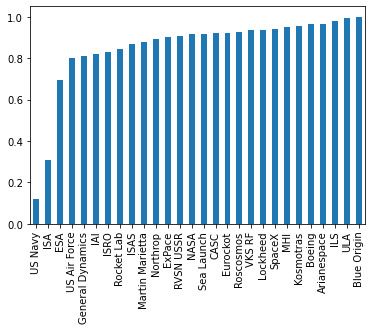

In [7]:
# only consider Companies with more than 10 launches
company_df_g10 = company_df[company_df['Launches'] >= 10]

# plot success rate by company for > 10 launches
company_df_g10.success_rate.sort_values().plot(kind="bar", use_index=True)
plt.show()


In [8]:
# look at top companies and their launch success
company_df_g10.sort_values(by=['success_rate'], ascending=False)

,success_rate,Launches,Company_Name
Blue Origin,1.000000,12,Blue Origin
ULA,0.992857,140,ULA
ILS,0.978261,46,ILS
Arianespace,0.964158,279,Arianespace
Boeing,0.963235,136,Boeing
Kosmotras,0.954545,22,Kosmotras
MHI,0.952381,84,MHI
SpaceX,0.940000,100,SpaceX
Lockheed,0.936709,79,Lockheed
VKS RF,0.935323,201,VKS RF


# Qustion: Has success rate improved through time? 

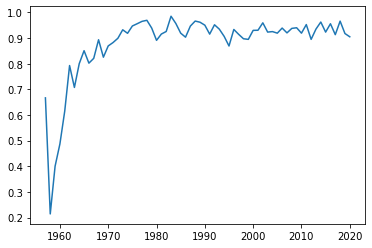

In [9]:
# Create df with each row = year, columns = ['YEAR' 'success_rate', 'n']
# Get Success Rate by year
success_rate = space_df.groupby(['YEAR'])['Success'].mean()
# Get N
year_launches = space_df.YEAR.value_counts()
# Get mean money spent by year
rocket_costs = space_df.groupby(['YEAR'])['Rocket_Price'].mean()

# Combine summary dat
frames = [success_rate, year_launches, rocket_costs]
YEAR_df = pd.concat(frames, axis=1)
YEAR_df = YEAR_df.rename(columns={"Success": "success_rate", "YEAR": "Launches"})
YEAR_df['YEAR'] = YEAR_df.index

# Plot sucess by year
YEAR_df.sort_values(by=['YEAR']).success_rate.plot(kind="line", use_index=True)
plt.show()

We can smooth this plot by taking running average

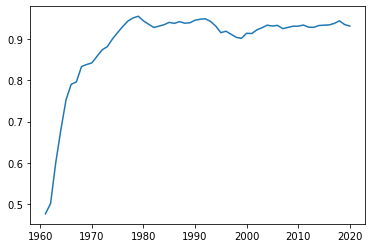

In [10]:
# Smooth data with 3 year running average
YEAR_df['success_mv_ave'] = YEAR_df.sort_values(by=['YEAR']).success_rate.rolling(window=5).mean()

# Plot smoothed sucess by year
YEAR_df.sort_values(by=['YEAR']).success_mv_ave.plot(kind="line", use_index=True)
plt.show()

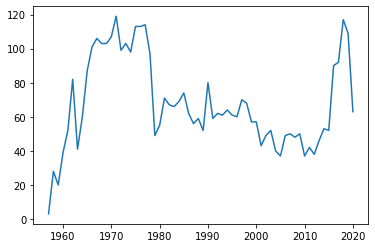

In [11]:
# Plot launches by year
YEAR_df.sort_values(by=['YEAR']).Launches.plot(kind="line", use_index=True)
plt.show()

While launch success has remained fairly constant since the mid-70's, the number of launches has changed substantially. Decreases from the 70's through the great recession of 2008-2010, but dramatic increases in launches from 2013 through the present. The final year 2020 is not complete, and hence shows a drop in total launches. 

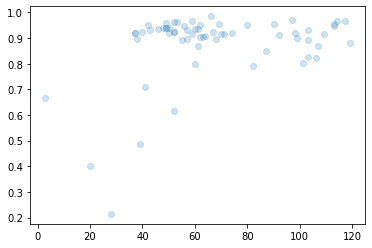

In [14]:
# Look at launches and success rate
plt.plot(YEAR_df.Launches, YEAR_df.success_rate, 'o', alpha=0.2);
plt.show()

In [13]:
# Create simple linear fit model to see if the number of launches
# per year is related to success rate.

# create dataframe for X,y
X = YEAR_df[['Launches']]
y = YEAR_df['success_rate']

# split out some training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

# initialize and fit model
lm_model = LinearRegression(normalize=True) 
lm_model.fit(X_train, y_train) 

# predict response with testing dataset 
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train) 

# simple test metric of R2
train_score = r2_score(y_train, y_train_preds)
test_score = r2_score(y_test, y_test_preds)

print(train_score)
print(test_score)

0.14025825752007548
-0.00021890414969671923


R2 test score is very low. We will need additional stats to determine if total number of launches per year show any relationship with launch success. 

# Question: Has the day of the week or the week of the year of launch changed over the past ~ 50 years? 

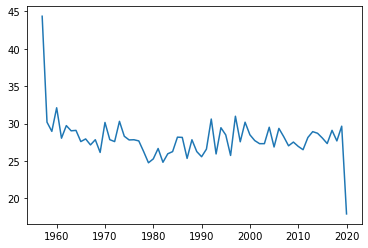

In [15]:
# Get Success Rate by year
success_rate = space_df.groupby(['YEAR'])['Success'].mean()
# Get N
year_launches = space_df.YEAR.value_counts()
# Get mean week by year
mean_week = space_df.groupby(['YEAR'])['WEEK'].mean()

# Combine summary dat
frames = [success_rate, year_launches, mean_week]
YEAR_df = pd.concat(frames, axis=1)
YEAR_df = YEAR_df.rename(columns={"Success": "success_rate", "YEAR": "Launches"})
YEAR_df['YEAR'] = YEAR_df.index

# Plot mean WEEK by year
YEAR_df.sort_values(by=['YEAR']).WEEK.plot(kind="line", use_index=True)
plt.show()

If we ignore the first and last years, the week that a launch occurrs on has not really changed through time. This is good. 

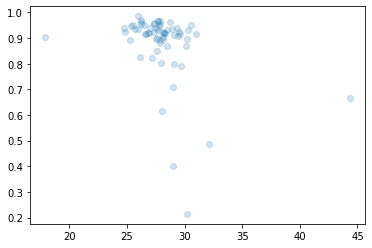

In [19]:
# Look at mean week and success rate
plt.plot(YEAR_df.WEEK, YEAR_df.success_rate, 'o', alpha=0.2);
plt.show()

In [17]:
# Create simple linear fit model to see if the mean week 
# per year is related to success rate.

# create dataframe for X,y
X = YEAR_df[['WEEK']]
y = YEAR_df['success_rate']

# split out some training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

# initialize and fit model
lm_model = LinearRegression(normalize=True) 
lm_model.fit(X_train, y_train) 

# predict response with testing dataset 
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train) 

# simple test metric of R2
train_score = r2_score(y_train, y_train_preds)
test_score = r2_score(y_test, y_test_preds)

print(train_score)
print(test_score)

0.08296849033184284
0.26202433883044896


R2 test score is super low. We will need additional stats to determine if week of year shows any relationship with launch success. 

# Does launch success improve with experience?

In [20]:
# Create dummy column with total number of launches by year for that particular company.
# we will use this to get cumulative launches for each company at a given launch.  
space_df['Index1'] = 1
# Create column to store cumulative values 
space_df['CumLaunches'] = 1
# create blank dataset to join with
joindat = pd.DataFrame(columns = space_df.columns)

# Function to create cumulative launch number for each launch by company. 
# For example, for a given company, that has 10 launches, we want to see if the
# probability of success increases from the first to the last launch. Ie, does having more launches
#  equate to higher launch success.
def create_sum_launches(df, joindat, companies):
	for cp in  companies:
			try:
				x = df[df['Company_Name'] == cp].sort_values(by=['date_time'])
				x['CumLaunches'] = x.Index1.cumsum()
				frames = [joindat, x]
				joindat = pd.concat(frames, axis=0)
			except:
				continue
	return joindat

companies = space_df.Company_Name.unique()
cumulative_launches_df = create_sum_launches(space_df, joindat, companies)
print(cumulative_launches_df.head)

<bound method NDFrame.head of      SucessFail Company_Name  Rocket_Price  date_time  YEAR MONTH  WEEK  \
929     Failure       SpaceX           7.0 2006-03-24  2006     3    12   
879     Failure       SpaceX           7.0 2007-03-21  2007     3    12   
808     Failure       SpaceX           7.0 2008-08-03  2008     8    31   
800     Success       SpaceX           7.0 2008-09-28  2008     9    39   
763     Success       SpaceX           7.0 2009-07-14  2009     7    29   
...         ...          ...           ...        ...   ...   ...   ...   
4300    Failure      US Navy           NaN 1958-09-26  1958     9    39   
4291    Success      US Navy           NaN 1959-02-17  1959     2     8   
4288    Failure      US Navy           NaN 1959-04-14  1959     4    16   
4285    Failure      US Navy           NaN 1959-06-22  1959     6    26   
4277    Failure      US Navy           NaN 1959-09-18  1959     9    38   

     WEEKDAY Failure Success Index1 CumLaunches  
929      Fri       

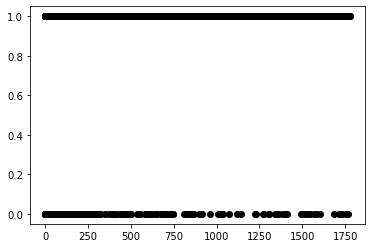

In [21]:
# Plot success by cumulative launches
plt.plot(cumulative_launches_df.CumLaunches, cumulative_launches_df.Success, 'o', color='black');
plt.show()

Doesn't look like there is much evidence for cumulative launches = higher success probability. 

In [28]:
#  Create simple linear fit model to see if the mean week 
# per year is related to success rate.

# create dataframe for X,y
X = cumulative_launches_df[['CumLaunches', 'YEAR']]
y = cumulative_launches_df['Success']
# set y as integer for Logistic Regression
y=y.astype('int')

# split out some training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

# linear Regression
lm_model = LinearRegression(normalize=True) 
lm_model.fit(X_train, y_train) 

# predict response with testing dataset 
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train) 

# simple test metric of R2
train_score = r2_score(y_train, y_train_preds)
test_score = r2_score(y_test, y_test_preds)

print(train_score)
print(test_score)

0.05778764027452521
0.024107327272934076


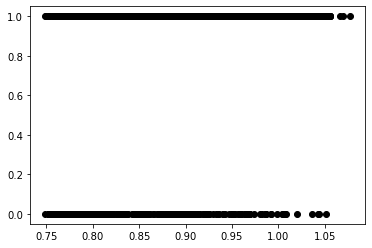

In [29]:
# Look at train y & y predictions
plt.plot(y_train_preds, y_train, 'o', color='black');
plt.show()

Clearly poor fitting model that is not appropriate for these data. Will need to look into other model forms. Possibly a threshold with cumulative launches, such that non-linear (GAM, or such) could be useful.  